## Desciption

Here, we are training a model to predict both the transcription initiation rate and the direction of transcription (forward or reverse). This model uses the same architecture as CNN_5_0, but uses augmented data that includes reversed complements.

This model predicts between -1 (reverse) and 1 (forward) with 0 being no transcription. It also uses CNN_6's preprocessing, where 1 is high TX, so -1 is highy TX (reversed) and 1 is highy TX (forward).

This version uses sklearn.utils.class_weight to compute balanced weights based on the actual label distribution.

In [1]:
import IsActive_1_1 as parent

In [2]:
name = 'IsActive_1_1'

In [3]:
import pandas as pd

file_path = '../Data/Urtecho_2023/Urtecho_2023.csv'

df = pd.read_csv(file_path)

In [4]:
# Displays only the first and last row
df.iloc[[0, -1]]

,promoter_sequence,expn_med_fitted_scaled,log_expn_med_fitted_scaled,active
0,TCCCGTGCTATGTTATTGACACACAAAAGCGTTGAGGAACAGTGAG...,0.467135,0.082044,0
45200,TGAATCACATCGCGCGCCCCGCGTGAGGCACCAAACAAGGCCTCTG...,0.125388,0.056093,0


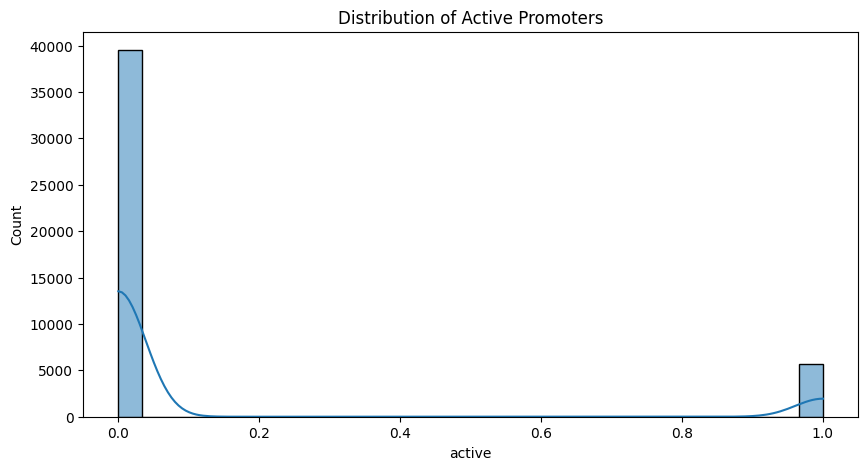

In [16]:
# graph the distribution of the 'active' column
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(df['active'], bins=30, kde=True)
plt.title('Distribution of Active Promoters')
plt.show()

In [5]:
X, y = parent.combine_columns(df)
X, max_length = parent.preprocess_sequences(X)

In [6]:
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y),
                                             y=y)

class_weight_dict = dict(zip(np.unique(y), weights))

print("Class weights:", class_weight_dict)


Class weights: {0: 0.5719618363111808, 1: 3.9740636539475998}


In [7]:
X_train, X_val, y_train, y_val = parent.train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = parent.train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((36160, 150, 4), (4521, 150, 4), (4520, 150, 4), (36160,), (4521,), (4520,))

In [8]:
# Convert to numpy arrays so that the class_weight_dict is compatible
y_train = np.array(y_train)
y_val = np.array(y_val)

In [9]:
model = parent.build_cnn_model(X.shape[1:])
history = parent.train_model(model, X_train, y_train, X_val, y_val, class_weight_dict)
loss = parent.evaluate_model(model, X_test, y_test)
parent.save_model(model, name)

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5619 - loss: 0.6721 - val_accuracy: 0.6410 - val_loss: 0.5936
Epoch 2/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5822 - loss: 0.6300 - val_accuracy: 0.5370 - val_loss: 0.6457
Epoch 3/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5930 - loss: 0.5963 - val_accuracy: 0.5881 - val_loss: 0.6127
Epoch 4/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6447 - loss: 0.5482 - val_accuracy: 0.6757 - val_loss: 0.5359
Epoch 5/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7120 - loss: 0.4761 - val_accuracy: 0.6572 - val_loss: 0.6203
Epoch 6/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7654 - loss: 0.4070 - val_accuracy: 0.7335 - val_loss: 0.4904
Epoch 7/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8111 - loss: 0.3469 - val_accuracy: 0.7337 - val_loss: 0.5180
Epoch 8/150
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8511 - loss: 0

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


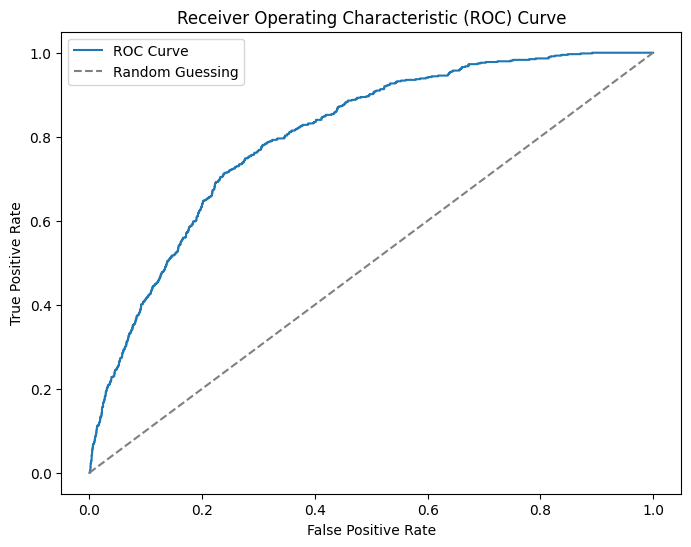

In [10]:
predicted = parent.load_and_predict(name, X_test)
observed = y_test

parent.plot_roc_curve(observed, parent.ravel(predicted))

In [11]:
for metric, value in loss.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.7792
precision: 0.3224
recall: 0.6327
f1_score: 0.4271
auc: 0.8019


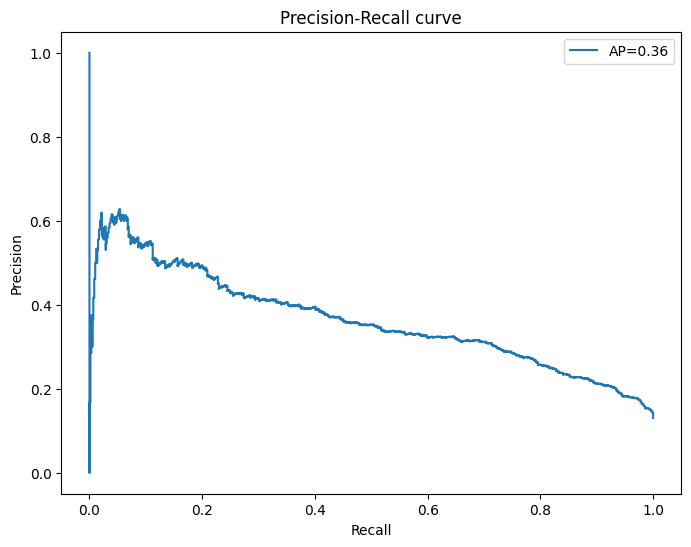

In [ ]:
# make precision–recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score

# Compute precision and recall
precision, recall, _ = precision_recall_curve(observed, predicted)
average_precision = average_precision_score(observed, predicted)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'AP={average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()